### Importing all Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
data = pd.read_csv('loan.csv')

##### Since the aim of this analysis is to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. 

#### The keywords used for borrowers :-

1) ##### `Fully paid`:  Applicant has fully paid the loan (the principal and the interest rate)

2) ##### `Current`:  Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'

3) ##### `Charged-off`:  Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan

##### As mentioned above, borrowers who are  in `Current` loan status can not be labelled either `Fully Paid` or `Charged Off` , so including them in our analysis is not fruitful. We will proceed with dataset containing only `Fully Paid` and `Charged Off`

In [3]:
df = data[~(data['loan_status'] == 'Current')]

In [4]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


##### Structure of Data

In [5]:
df.shape

(38577, 111)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38577 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.0+ MB


In [7]:
df.dtypes

id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object

In [8]:
df.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               38577
total_bal_ex_mort             38577
total_bc_limit                38577
total_il_high_credit_limit    38577
Length: 111, dtype: int64

In [9]:
df.duplicated().sum()

0

##### No Duplicates

##### SInce it's visible  that there are total `38577` entries and some columns have `38577`  null or missing values let's drop them

In [10]:
df = df.dropna(how='all',axis=1)

##### We have to drop some columns ,which does not have any impact on our target Column Explicitly or Implicitly

In [11]:
df = df.drop(columns=['id','member_id','url','desc'])

In [12]:
df.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                           object
int_rate                       object
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line               object
inq_last_6mths                  int64
mths_since_last_delinq        float64
mths_since_last_record        float64
open_acc    

##### Also all The colmns related to recovery need to dropped  like `recoveries` and `collection_recovery_fee` cause they come in picture after declaration of `Charged Off`

In [13]:
df = df.drop(columns=['recoveries','collection_recovery_fee'])

##### Some columns have more than `60%`  even `90%` missing or null values ,it's better to drop them

In [14]:
df = df.drop(columns=['mths_since_last_delinq','mths_since_last_record'])

##### now let's check the shape

In [15]:
df.shape

(38577, 48)

In [16]:
df.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,171.62,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,119.66,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


##### Let's treat `emp_length`  column ,so that we can impute missing values

##### we are taking `<1`  employment length as `0` and `10+` as 10 

In [17]:
df['emp_length'].value_counts()

emp_length
10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: count, dtype: int64

In [18]:
df['emp_length'] = df['emp_length'].str.replace('10+','10')
df['emp_length'] = df['emp_length'].str.replace('< 1','0')
df['emp_length'] = df['emp_length'].str.replace('years','')
df['emp_length'] = df['emp_length'].str.replace('year','')

##### Imputing with `mode` in column

In [19]:
df['emp_length'].mode()

0    10 
Name: emp_length, dtype: object

In [20]:
df['emp_length'] = df['emp_length'].fillna(10)

In [21]:
df['emp_length'] = df['emp_length'].astype(int)

In [22]:
df.isnull().mean() * 100

loan_amnt                     0.000000
funded_amnt                   0.000000
funded_amnt_inv               0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
grade                         0.000000
sub_grade                     0.000000
emp_title                     6.185033
emp_length                    0.000000
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
pymnt_plan                    0.000000
purpose                       0.000000
title                         0.028514
zip_code                      0.000000
addr_state                    0.000000
dti                           0.000000
delinq_2yrs                   0.000000
earliest_cr_line              0.000000
inq_last_6mths                0.000000
open_acc                      0.000000
pub_rec                  

##### Still we have some missing or null values , But they are either very small in number or not very useful so dropping them

In [23]:
df = df.dropna(axis=0)

##### Finally we have `zero` null or missing values ,now we can proceed

In [24]:
df.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prnc

### Data Cleaning

##### Pre-analysis cleaning of some column  to ensure that the data is in a suitable and analyzable format
#####  `term` :- extracting months and converting in `int` format

In [25]:
term = df['term'].str.split()
df['term'] = term.apply(lambda x: x[0]).astype(int)

##### `int_rate` :- stripping `%` from columns and converting into `float`

In [26]:
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)

##### Extracting grade value from Sub Grade and converting into `int`

In [27]:
df['sub_grade'] = df['sub_grade'].str.replace(r'\D','',regex=True)
df['sub_grade'] = df['sub_grade'].astype(int)

##### Spliting `Month` and `Year` from `issue_d`

In [28]:
issue_d = df['issue_d'].str.split('-')
df['issue_month'] = issue_d.apply(lambda x : x[0])
df['issue_year'] = issue_d.apply(lambda x : x[1])

##### Dropping Original Column `issue_d`

In [29]:
df = df.drop(columns='issue_d')

##### Cleaning Zip Code 

In [30]:
df['zip_code'] = df['zip_code'].apply(lambda x : x[:-2])

##### Striping `%` from `revol_util`  and converting into Float

In [31]:
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float)

In [32]:
df.dtypes

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                            int32
int_rate                      float64
installment                   float64
grade                          object
sub_grade                       int32
emp_title                      object
emp_length                      int32
home_ownership                 object
annual_inc                    float64
verification_status            object
loan_status                    object
pymnt_plan                     object
purpose                        object
title                          object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line               object
inq_last_6mths                  int64
open_acc                        int64
pub_rec                         int64
revol_bal                       int64
revol_util  

##### Dividing numerical and Categorical Columns into `num_cols` and `cat_cols` 

In [33]:
num_cols = ['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','sub_grade','annual_inc','dti',
            'delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv',
           'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','last_pymnt_amnt','collections_12_mths_ex_med','policy_code','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt',
            'pub_rec_bankruptcies','tax_liens']

In [34]:
cat_cols = ['grade','emp_length','home_ownership','verification_status','loan_status','pymnt_plan','zip_code','addr_state','last_pymnt_d','last_credit_pull_d','application_type','issue_month','issue_year']

### Visualization of data distribution

##### Plotting `num_cols` one by one 

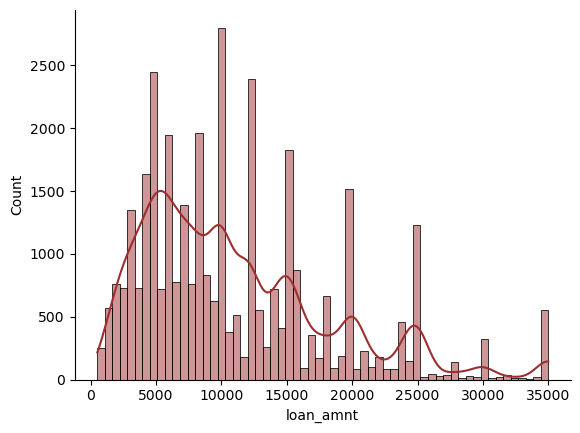

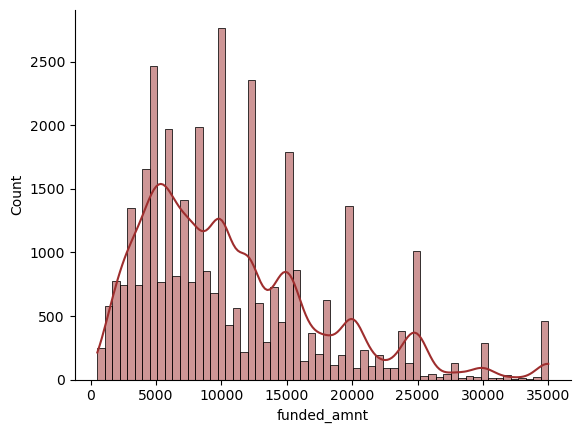

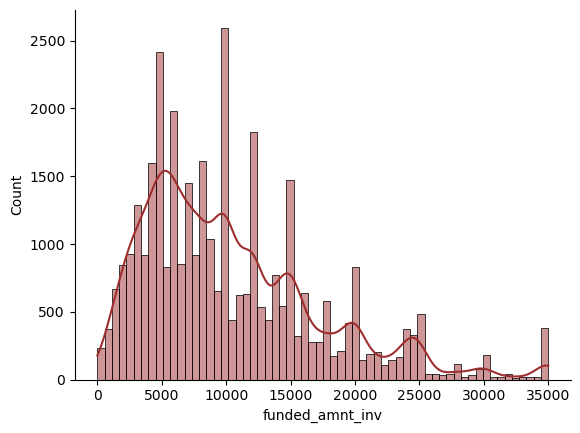

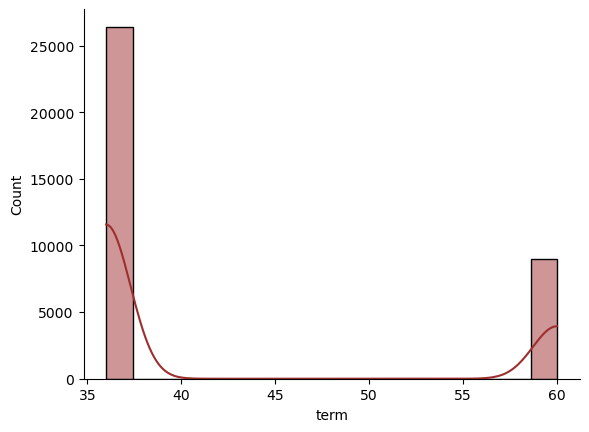

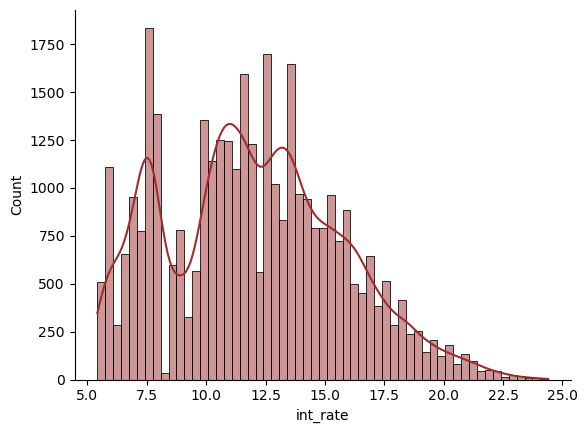

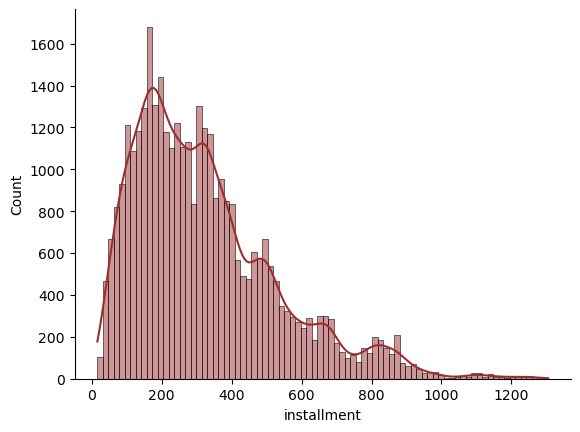

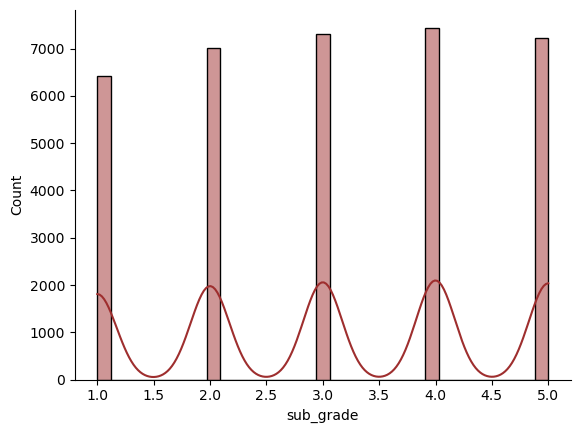

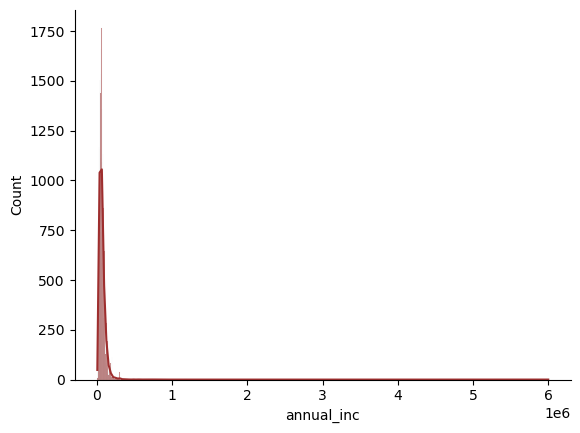

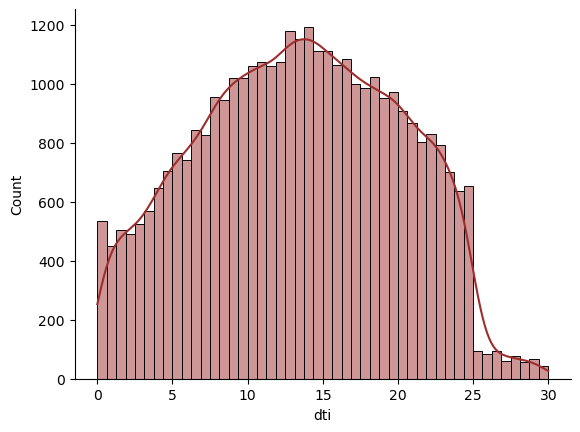

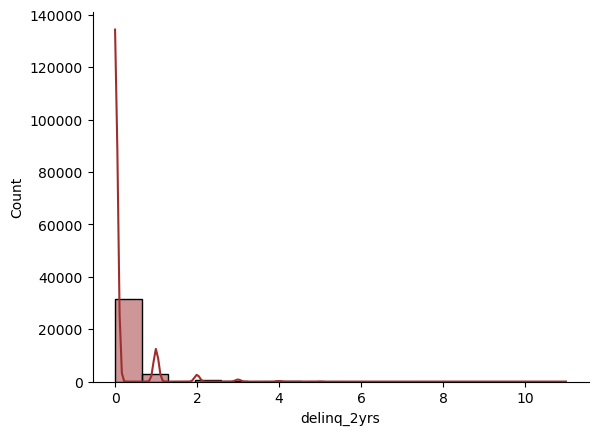

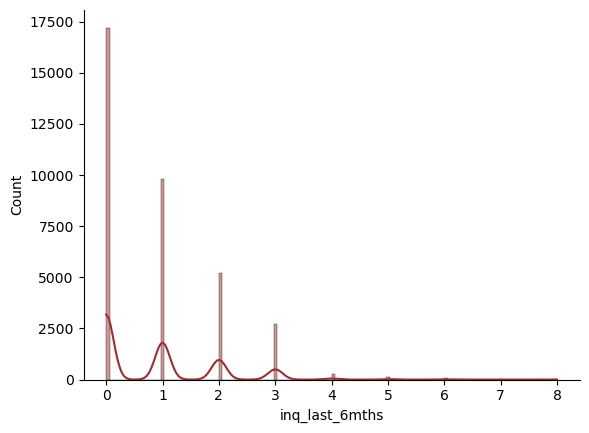

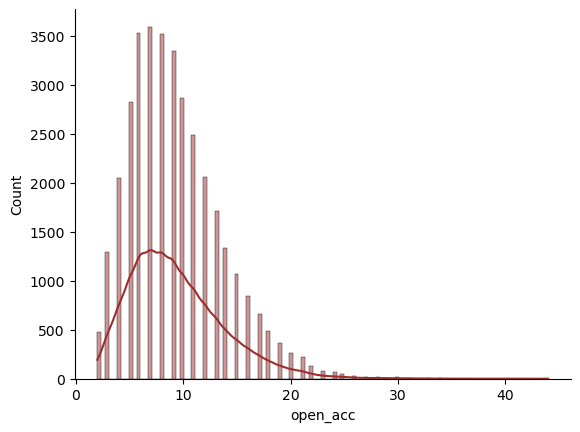

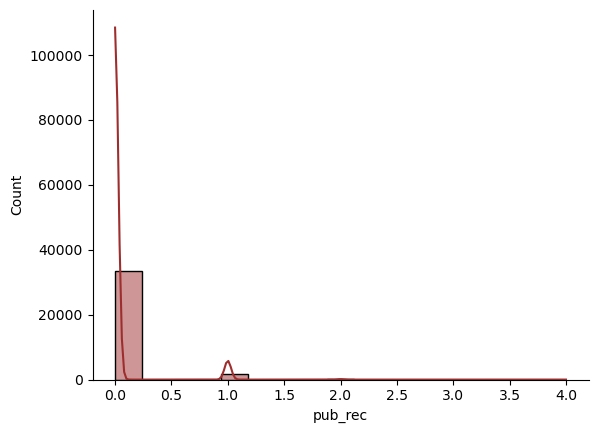

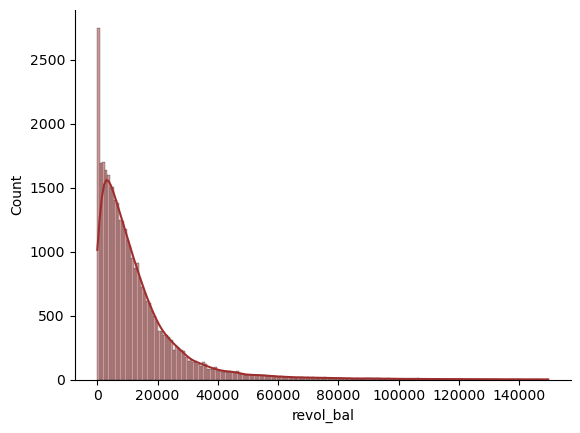

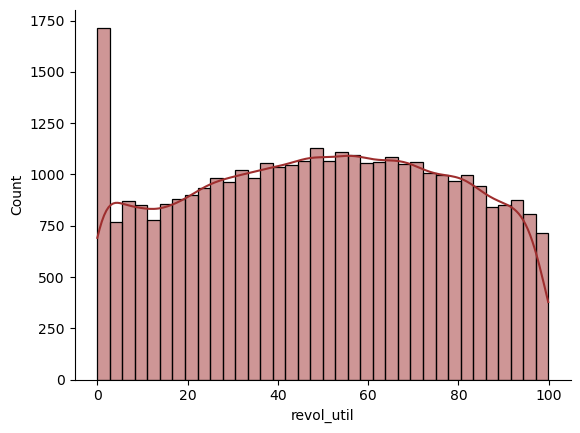

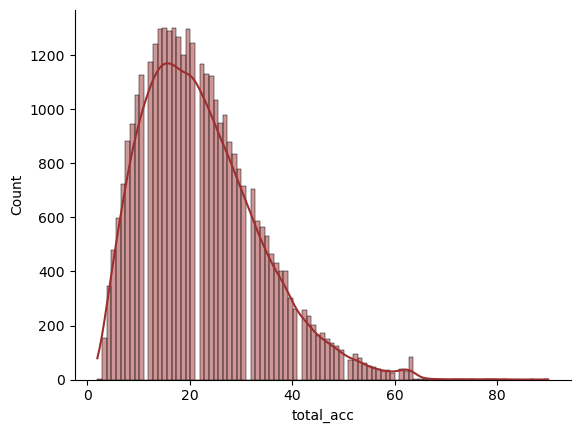

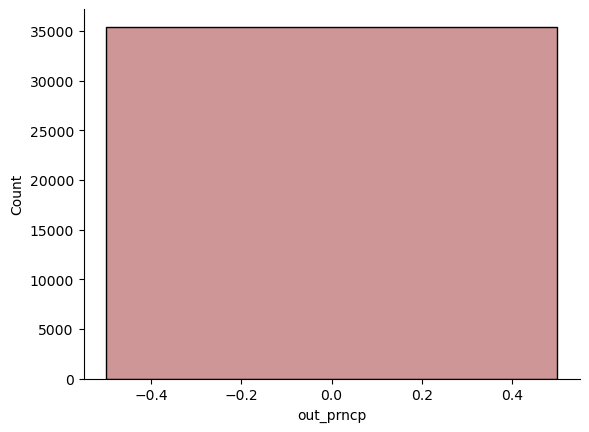

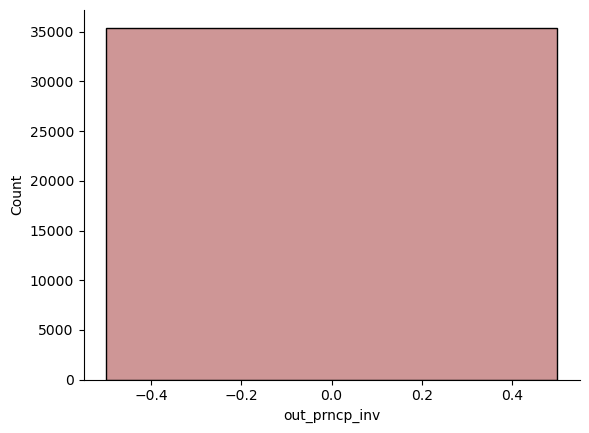

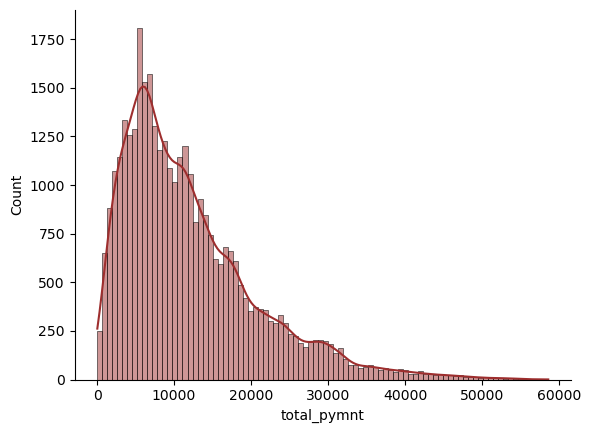

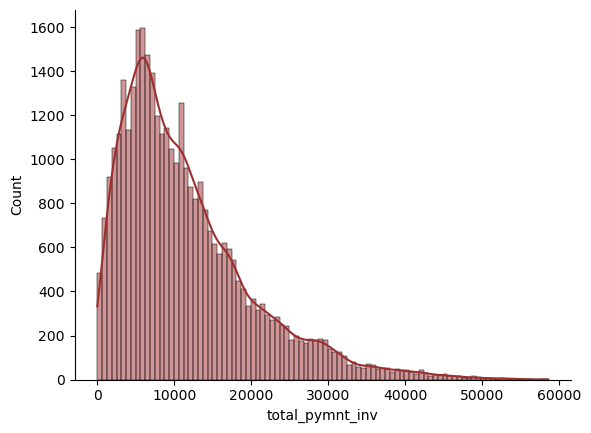

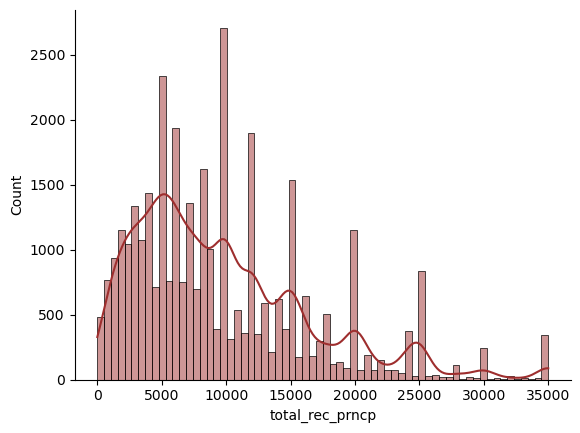

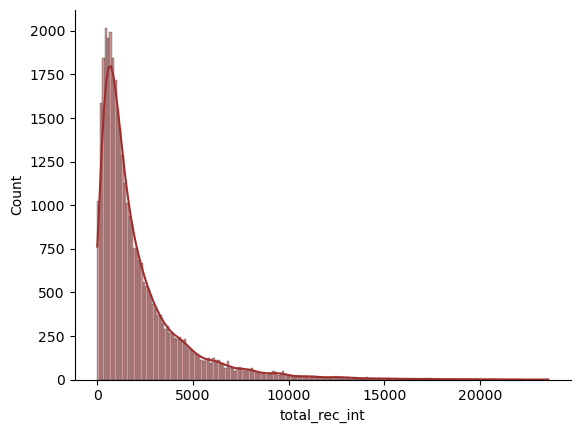

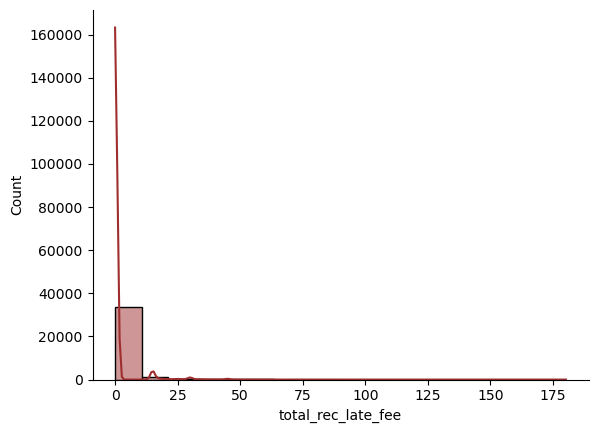

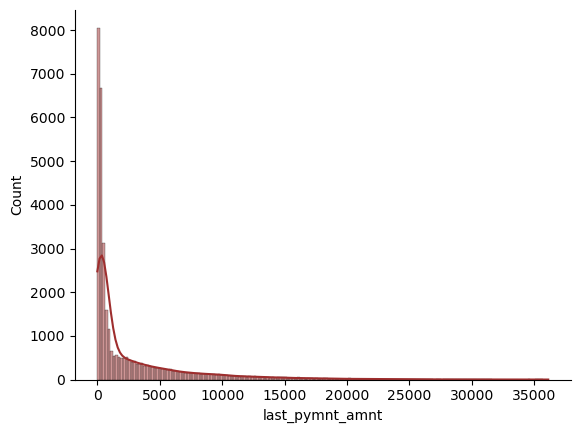

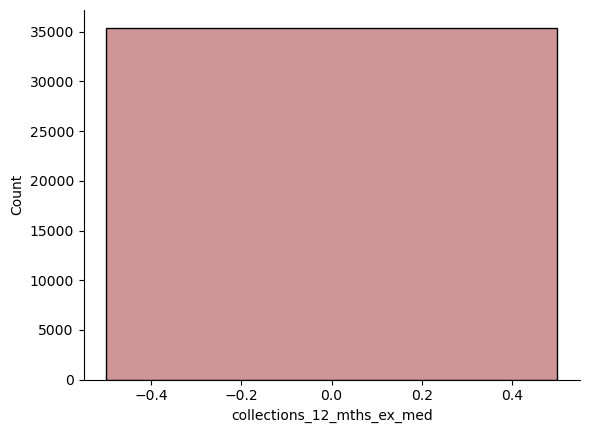

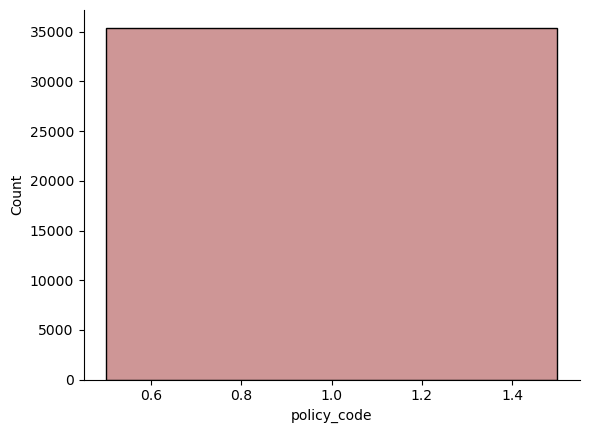

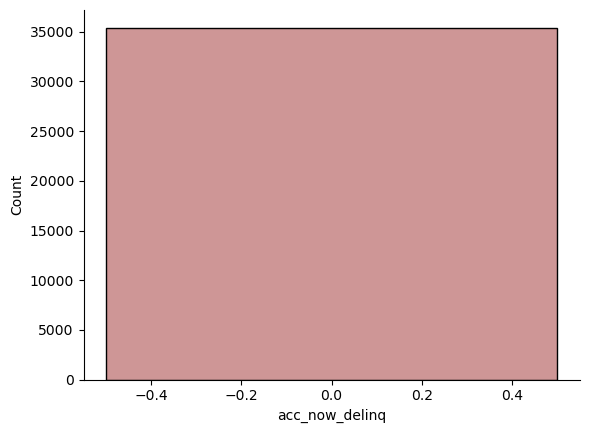

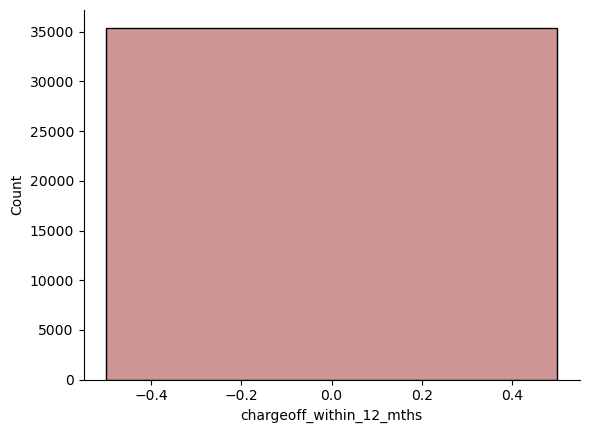

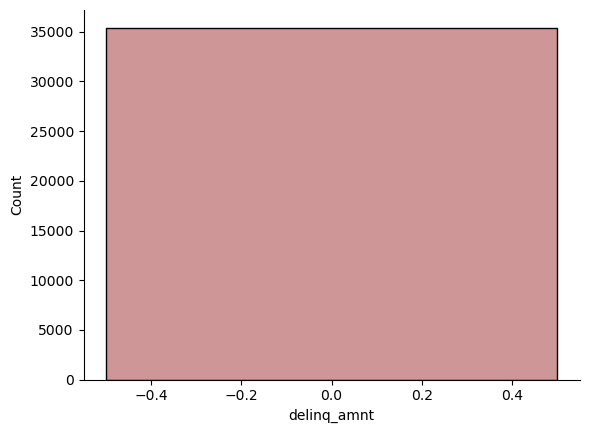

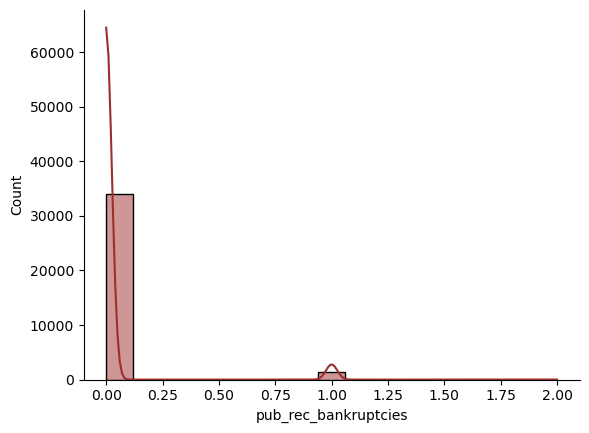

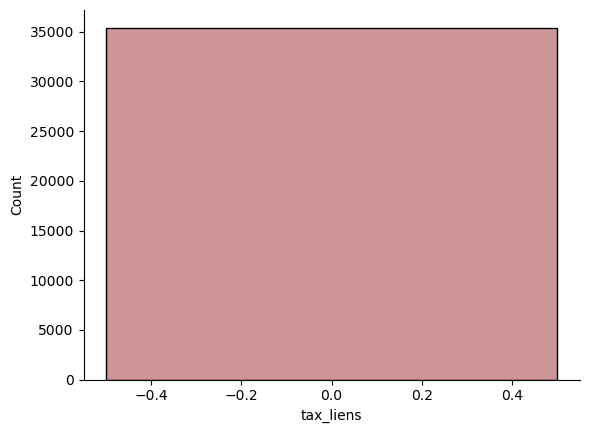

In [35]:
for col in num_cols:
    sns.histplot(df[col],kde=True,color='#9e2e2e')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

##### Plotting `cat_cols` one by one

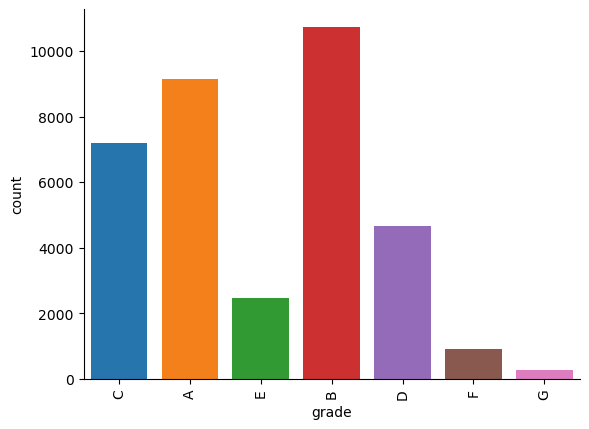

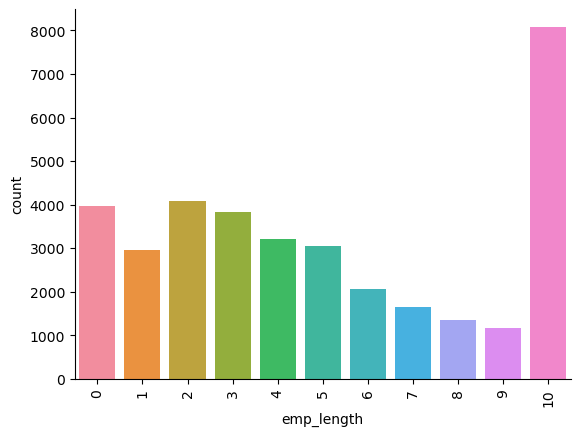

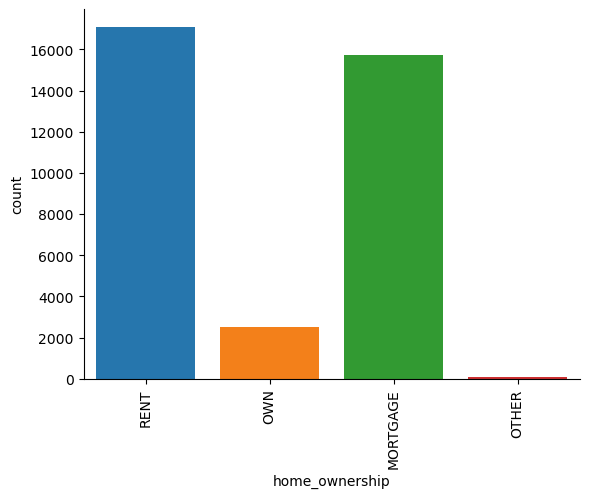

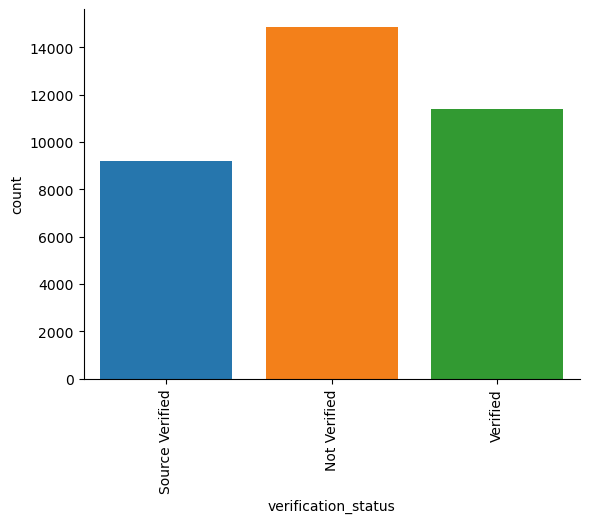

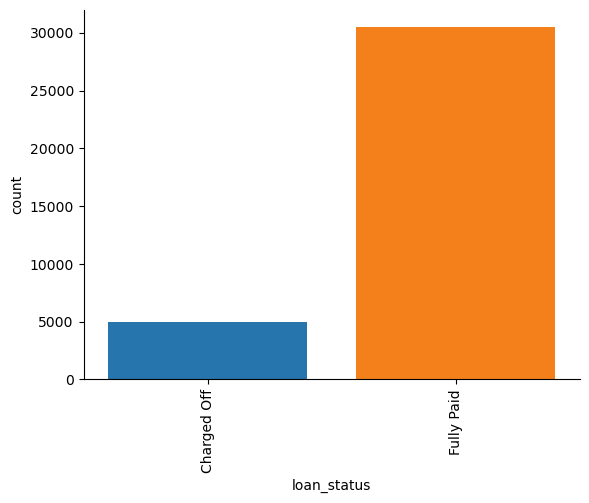

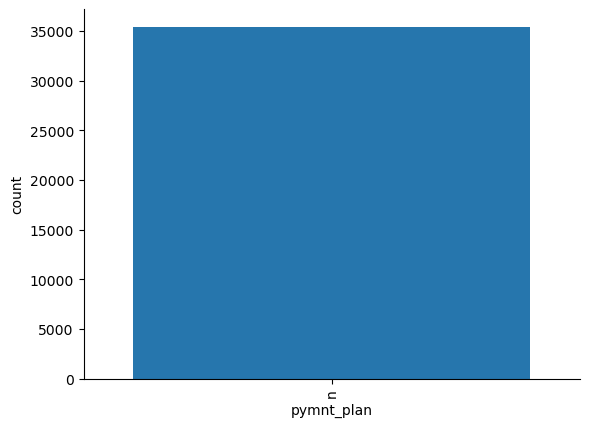

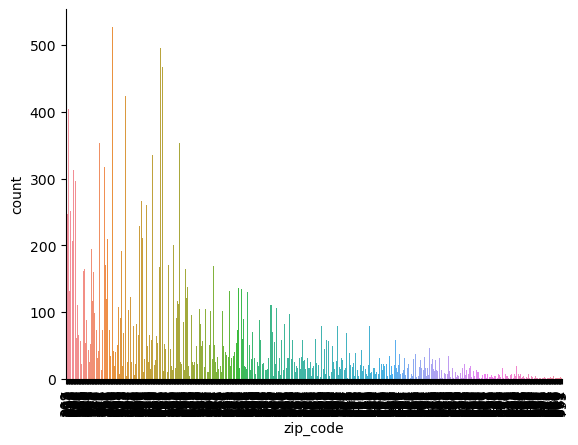

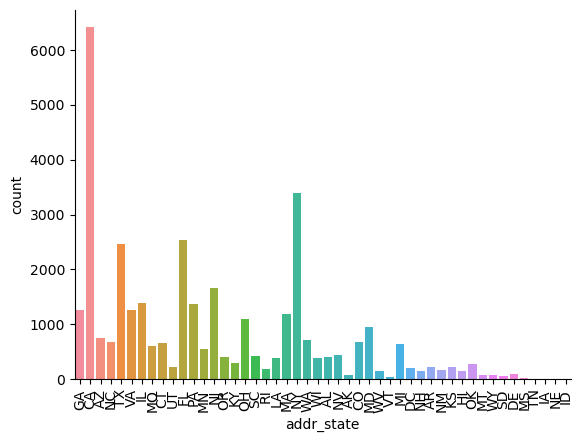

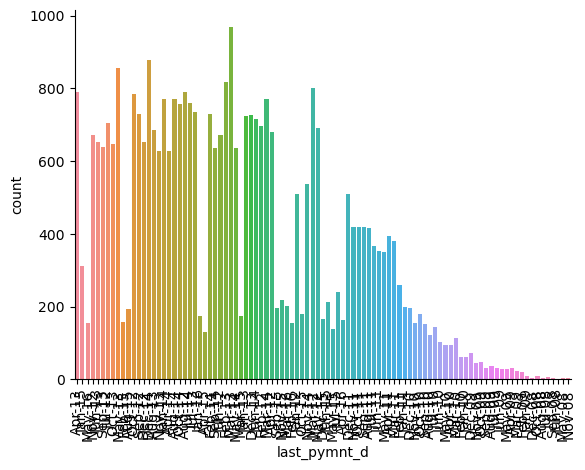

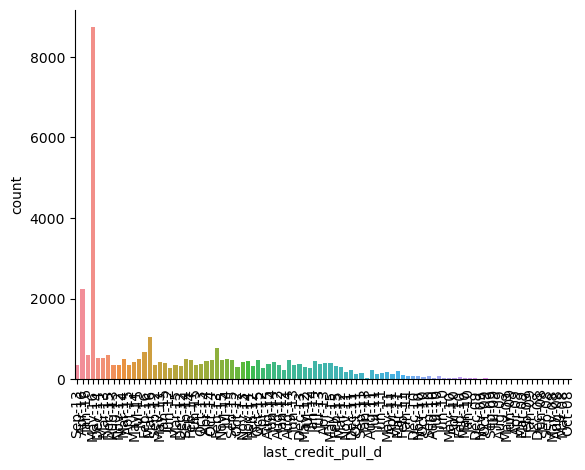

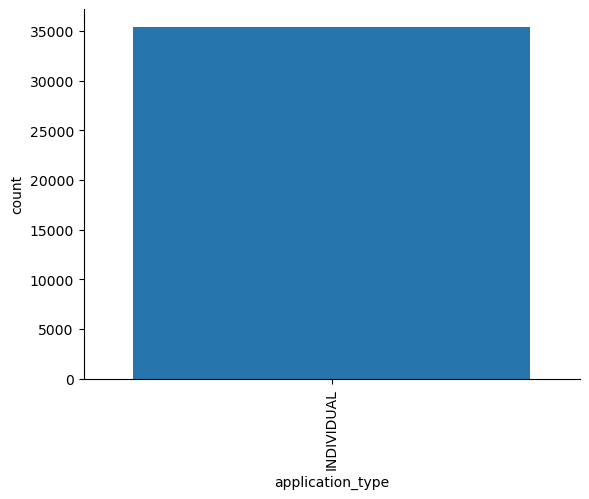

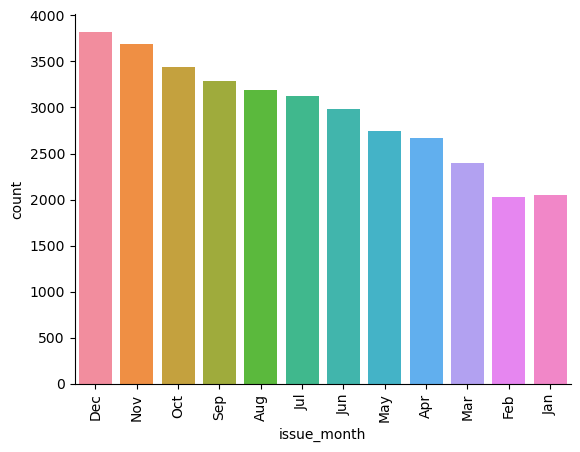

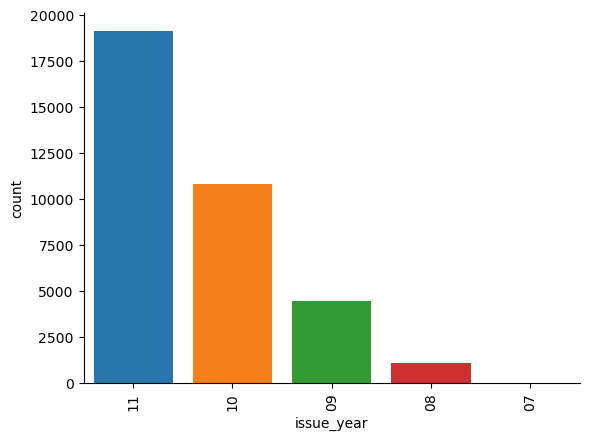

In [36]:
for col in cat_cols:
    sns.countplot(x = df[col],saturation=0.9)
    plt.xticks(rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.show()

##### Since from the above Graphs,we can observe some Columns have exactly one value ,it does not add any value in our analysis ,let's drop them

In [37]:
df = df.drop(columns=['out_prncp','out_prncp_inv','collections_12_mths_ex_med','policy_code','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','tax_liens'])

##### Similarly for `cat_cols` some column has exactly same value across all entries , so it's better to drop them

In [38]:
df = df.drop(columns=['pymnt_plan','application_type'])

In [39]:
df.shape

(35420, 39)

### Handling Outliers

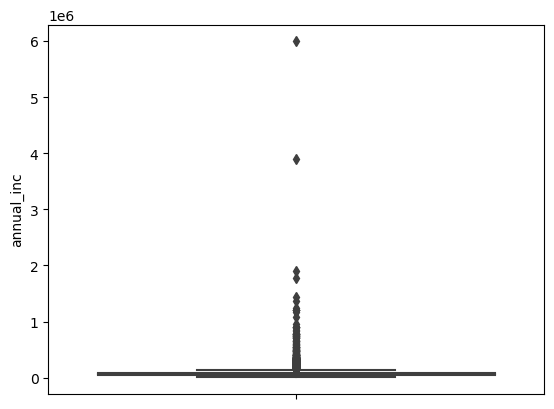

In [40]:
sns.boxplot(y = df['annual_inc'])
plt.show()

##### Clearly , as above we have lots of outlier points , lets see through quantile distribution

In [41]:
df['annual_inc'].describe()

count    3.542000e+04
mean     6.905993e+04
std      6.393480e+04
min      4.000000e+03
25%      4.144821e+04
50%      6.000000e+04
75%      8.245500e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [42]:
df['annual_inc'].quantile([0.25,0.5,0.75,0.95])

0.25     41448.21
0.50     60000.00
0.75     82455.00
0.95    140000.00
Name: annual_inc, dtype: float64

In [43]:
income_outliers = df[(df['annual_inc'] > 140000)]

In [44]:
df1 = df[~(df['annual_inc'] > 140000)]

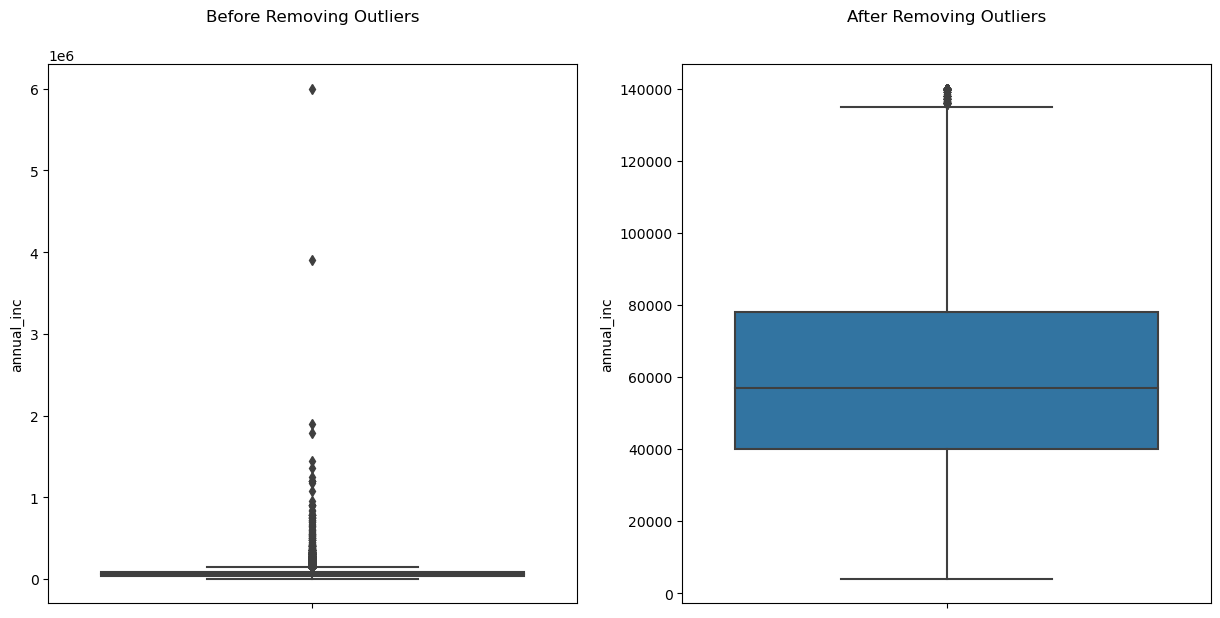

In [45]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.boxplot(y = df['annual_inc'])
plt.title('Before Removing Outliers\n\n')
plt.subplot(1,2,2)
sns.boxplot(y = df1['annual_inc'])
plt.title('After Removing Outliers\n\n')
plt.show()

In [46]:
income_outliers['loan_status'].value_counts()

loan_status
Fully Paid     1531
Charged Off     182
Name: count, dtype: int64

In [47]:
df['loan_status'].value_counts()

loan_status
Fully Paid     30466
Charged Off     4954
Name: count, dtype: int64

##### As after removing Income outliers we are loosing `182` entries out of `4954` entries but now our `annual income` Distrubution on histogram is much more like bell curve than before ,see here below

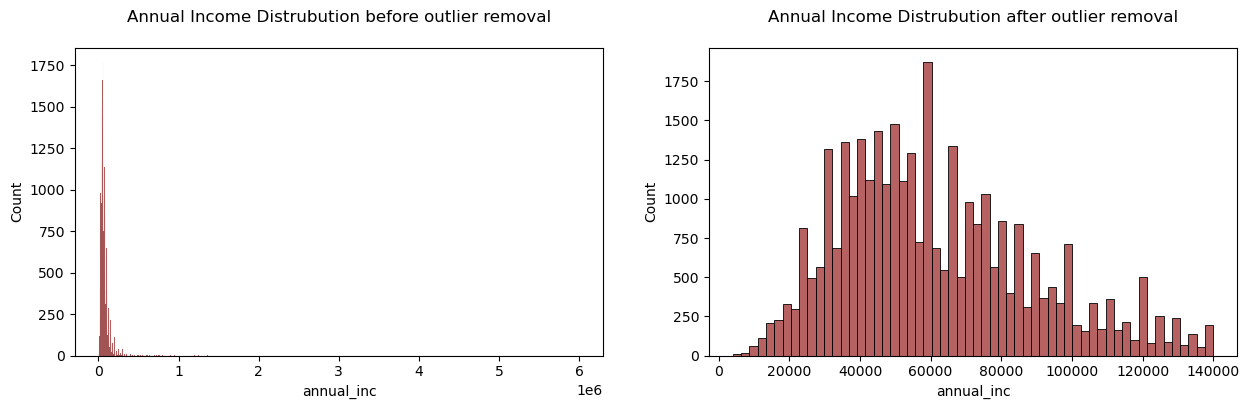

In [48]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.histplot(df['annual_inc'],color='#9e2e2e')
plt.title('Annual Income Distrubution before outlier removal\n')
plt.subplot(1,2,2)
sns.histplot(df1['annual_inc'],color='#9e2e2e')
plt.title('Annual Income Distrubution after outlier removal\n')
plt.show()

### We are going to convert some numerical columns into categorical for better analysis

##### Converting `int_rate` into different category as shown below

In [49]:
pd.cut(df1['int_rate'],bins = 4 ,precision=0).value_counts()

int_rate
(10.0, 15.0]    15629
(5.0, 10.0]     10737
(15.0, 20.0]     6520
(20.0, 24.0]      821
Name: count, dtype: int64

In [50]:
df1['interest_rate'] = pd.cut(df1['int_rate'],bins = 4 , labels=['5% - 10%','10% - 15%','15% - 20%', '20%- 24%'],precision=0)

##### Converting `revol_util` into different category as shown below

In [51]:
pd.cut(df1['revol_util'],bins=4,precision=0).value_counts()

revol_util
(50.0, 75.0]     9141
(25.0, 50.0]     8898
(-0.1, 25.0]     8125
(75.0, 100.0]    7543
Name: count, dtype: int64

In [52]:
df1['revolving_util'] = pd.cut(df1['revol_util'],bins=4,precision=0,labels=['0% - 25%','25% - 50%','50% - 75%','75% - 100%'])

##### Converting `dti` into into different category as shown below

In [53]:
pd.cut(df1['dti'],bins = 4 ,precision=0).value_counts()

dti
(7.0, 15.0]     12136
(15.0, 22.0]    11264
(-0.0, 7.0]      6988
(22.0, 30.0]     3319
Name: count, dtype: int64

In [54]:
df1['Dti'] = pd.cut(df1['dti'],bins=4,precision=0,labels=['0% - 7%','7% - 15%','15% - 22%','22% - 30%'])

In [55]:
fully_paid = df1[df1['loan_status'] == 'Fully Paid']
charged_off = df1[df1['loan_status'] == 'Charged Off']

###  Descriptive statistics & Visualization

##### `Dti` is defined as  ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.


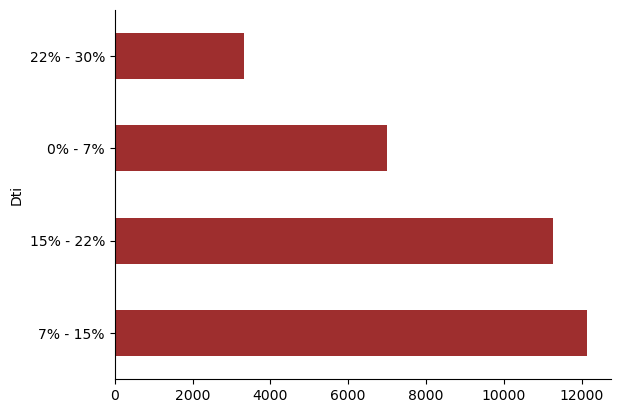

In [56]:
df1['Dti'].value_counts().plot(kind='barh',color='#9e2e2e')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

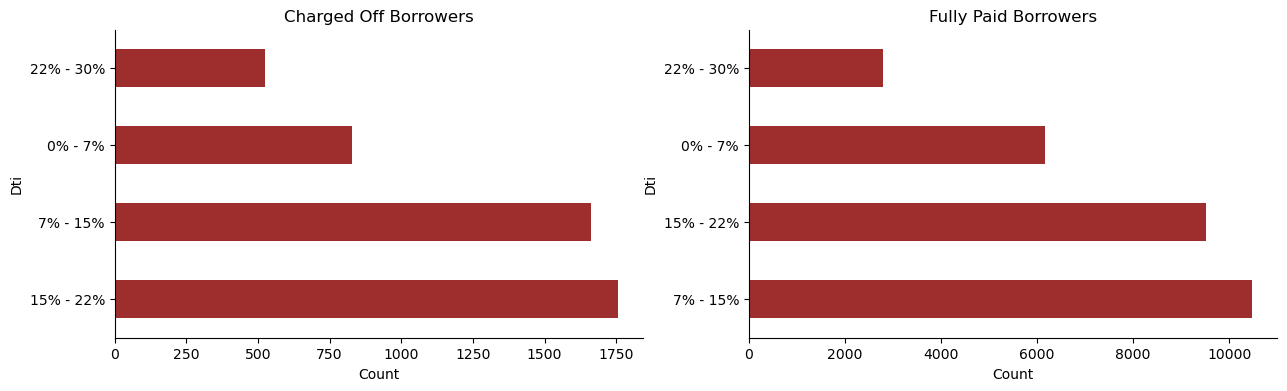

In [57]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
charged_off['Dti'].value_counts().plot(kind='barh',color='#9e2e2e')
plt.xlabel('Count')
plt.ylabel('Dti')
plt.title('Charged Off Borrowers')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.subplot(1,2,2)
fully_paid['Dti'].value_counts().plot(kind='barh',color='#9e2e2e')
plt.xlabel('Count')
plt.ylabel('Dti')
plt.title('Fully Paid Borrowers')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

##### Dti slabs of Charged Off Borrowers are in `15% - 22%` whereas for fully paid it is `7% -15%` 

In [58]:
pd.pivot_table(data =df1 ,index='loan_status',columns='issue_year',values='int_rate', aggfunc=['mean','median']).T

loan_status        Charged Off  Fully Paid
       issue_year                         
mean   07            12.490000   10.066667
       08            11.977237   11.153392
       09            13.050717   12.014731
       10            13.399455   11.503408
       11            14.316183   11.617489
median 07            12.490000   10.280000
       08            11.720000   11.140000
       09            12.870000   12.210000
       10            13.610000   11.360000
       11            14.270000   11.110000

### As it is visible from above that declared `Charged Off` borrowers are sanctioned loan on higher Interest rate than `Fully Paid` across the year from 2007 to 2011

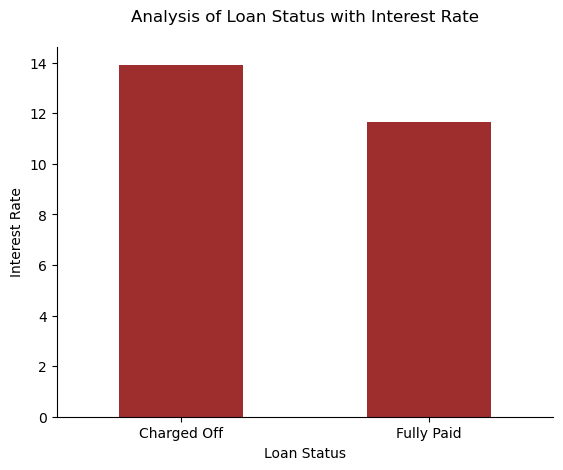

In [59]:
df.groupby(['loan_status'])['int_rate'].mean().plot(kind='bar',color='#9e2e2e')
plt.xlabel('Loan Status')
plt.xticks(rotation = 0)
plt.ylabel('Interest Rate')
plt.title('Analysis of Loan Status with Interest Rate\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.show()

### Charged Off Borrowers are paying high interest than fully paid borrowers 

#####  Lets see how  revolving Credit line is varying between `Charged Off` and `Fully Paid`

In [60]:
c = pd.pivot_table(data=df1 , index='loan_status',columns='verification_status',values='int_rate',aggfunc='mean')

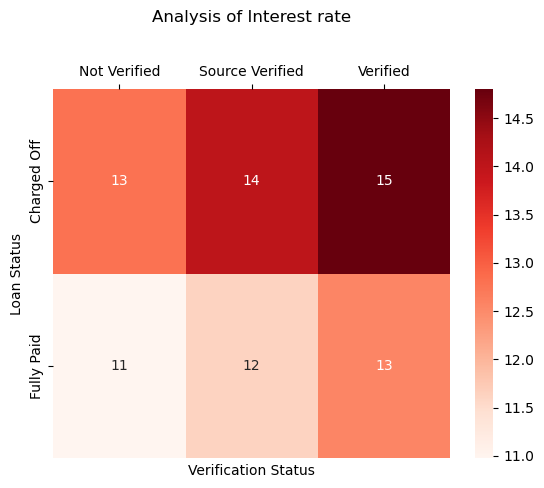

In [61]:
ax = sns.heatmap(c,annot=True,cmap='Reds',cbar=True)
ax.xaxis.tick_top()
plt.title('Analysis of Interest rate\n\n')
plt.xlabel('Verification Status')
plt.ylabel('Loan Status')
plt.show()

### It is quite visible from graph that charged Off borrrowers are paying high interest than fully paid borrowers ,irrespective of their verification of their income source.

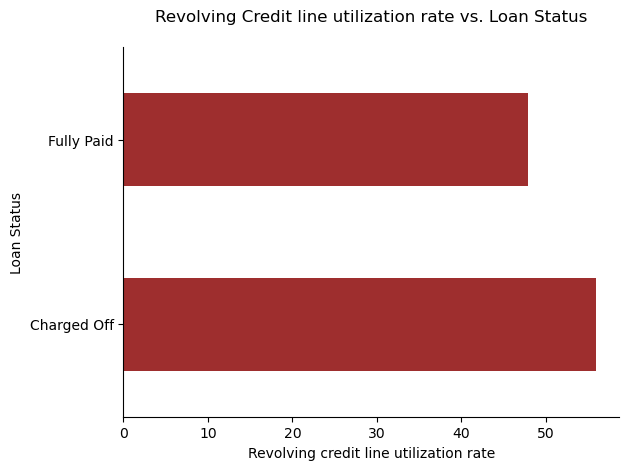

In [62]:
df1.groupby(['loan_status'])['revol_util'].mean().plot(kind='barh',color='#9e2e2e')
plt.xlabel('Revolving credit line utilization rate')
plt.ylabel('Loan Status')
plt.title('Revolving Credit line utilization rate vs. Loan Status\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Charged Off borrowers revolving credit line utilization rate are higher than fully poaid borrowers 

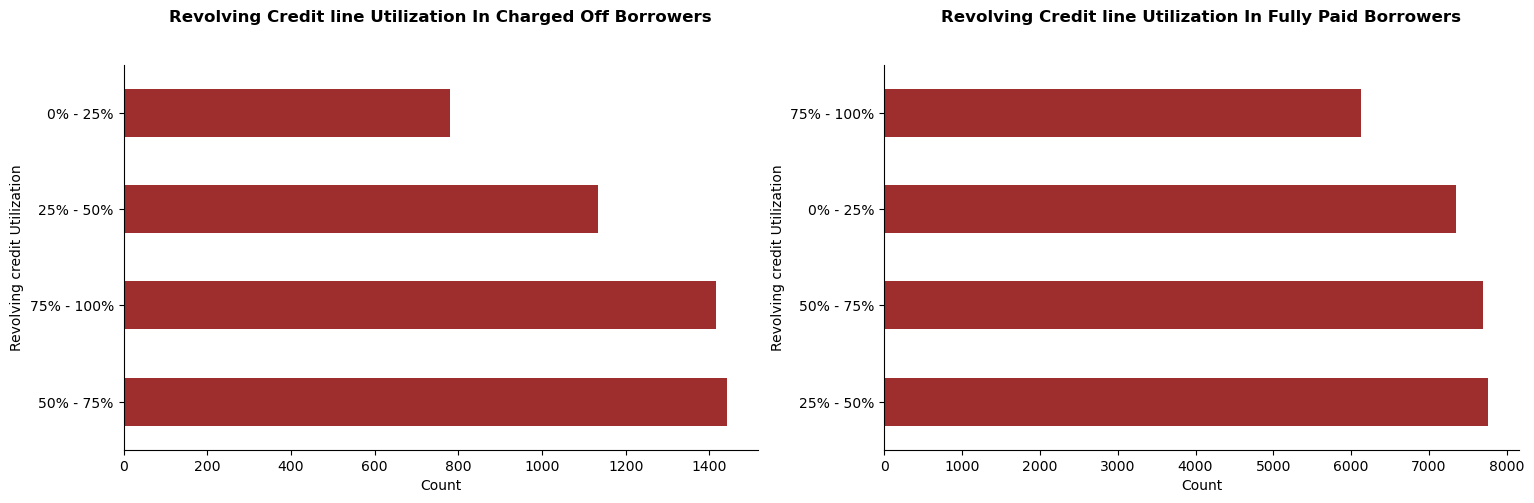

In [63]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
charged_off['revolving_util'].sort_values().value_counts().plot(kind='barh',color='#9e2e2e')
plt.xlabel('Count')
plt.ylabel('Revolving credit Utilization')
plt.title('Revolving Credit line Utilization In Charged Off Borrowers\n\n',fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.subplot(1,2,2)
fully_paid['revolving_util'].sort_values().value_counts().plot(kind='barh',color='#9e2e2e')
plt.xlabel('Count')
plt.ylabel('Revolving credit Utilization')
plt.title('Revolving Credit line Utilization In Fully Paid Borrowers\n\n',fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Visible from above graphs that `Charged Off` borrowers are utilizing higher revolving credit than `Fully Paid`

##### Lets Analyze `title` column and `emp_title` through WordColud

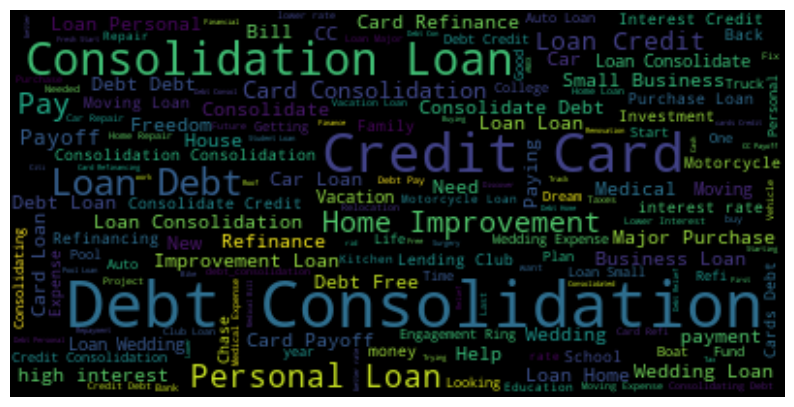

In [64]:
import wordcloud
from wordcloud import WordCloud
des = ' '.join([n for n in df1['title']])
description = WordCloud().generate(des)
plt.figure(figsize=(10,10))
plt.imshow(description,interpolation='bilinear')
plt.axis('off')
plt.show()

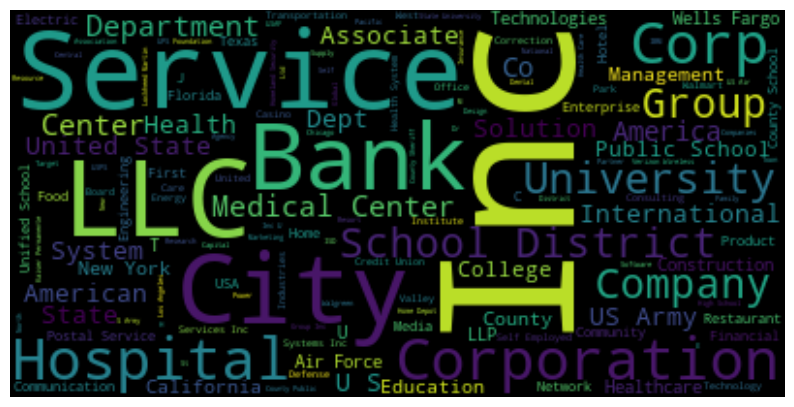

In [65]:
import wordcloud
from wordcloud import WordCloud
des = ' '.join([n for n in df1['emp_title']])
description = WordCloud().generate(des)
plt.figure(figsize=(10,10))
plt.imshow(description,interpolation='bilinear')
plt.axis('off')
plt.show()

##### Also Analyzing `purpose` column

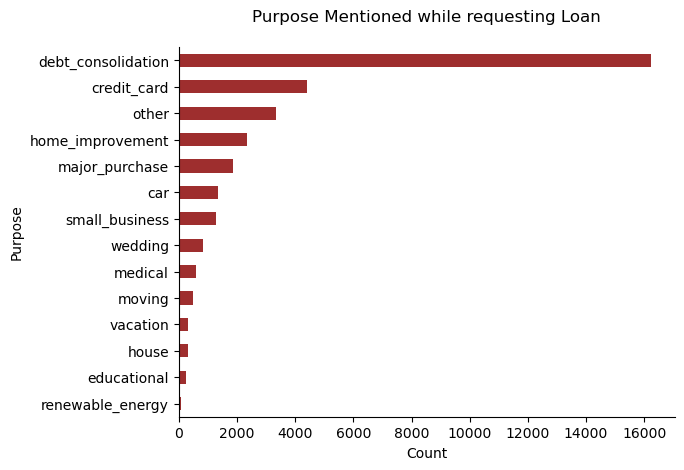

In [66]:
df1['purpose'].value_counts().sort_values().plot(kind='barh',color='#9e2e2e')
plt.title('Purpose Mentioned while requesting Loan\n')
plt.xlabel('Count')
plt.ylabel('Purpose')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.show()

### from both text analysis and graph shows that majority of quoted pupose is `debt_consolidation` and `credit_card`

##### Lets compare these  between `Charged Off` and `Fully Paid` simualtaneously

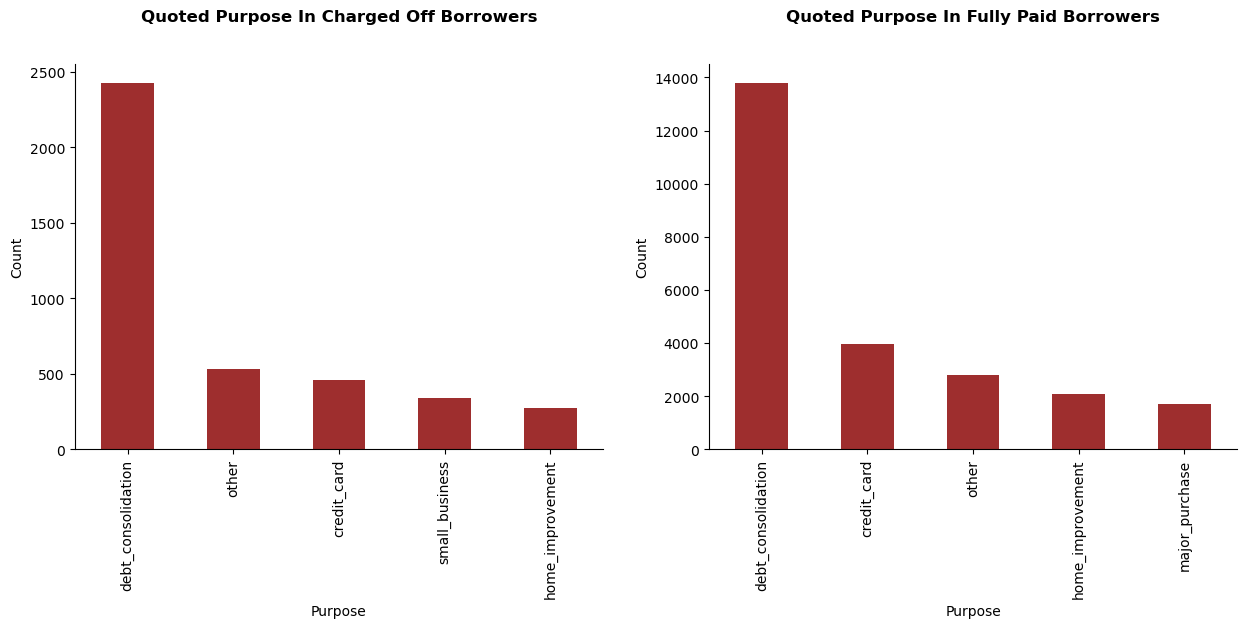

In [67]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
charged_off['purpose'].sort_values().value_counts().nlargest(5).plot(kind='bar',color='#9e2e2e')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Quoted Purpose In Charged Off Borrowers\n\n',fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.subplot(1,2,2)
fully_paid['purpose'].sort_values().value_counts().nlargest(5).plot(kind='bar',color='#9e2e2e')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Quoted Purpose In Fully Paid Borrowers\n\n',fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

##### We are creating a different dataframe under name `g` ,and which excule `debt_consolidation` since it is not useful enough to our analysis

In [68]:
g = df1[~(df1['purpose'] == 'debt_consolidation')]

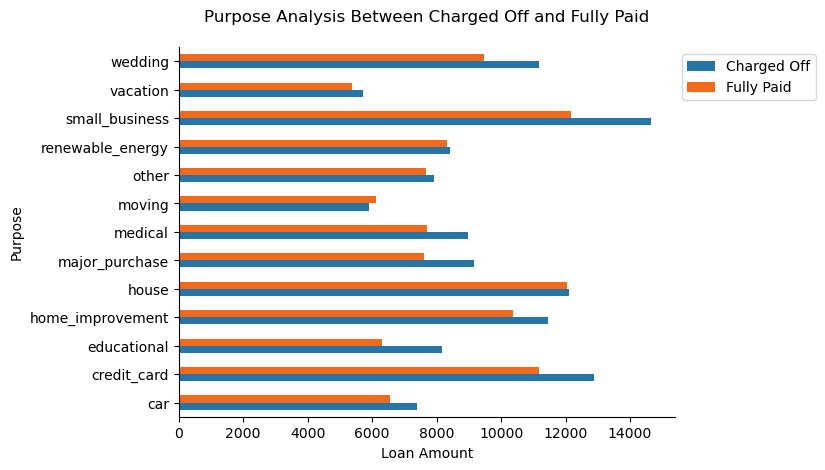

In [69]:
pd.pivot_table(data=g , index='loan_status' , columns='purpose' , values='loan_amnt',aggfunc='mean').T.plot(kind='barh',color=['#2675A6','#F26B1D'])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Loan Amount')
plt.ylabel('Purpose')
plt.title('Purpose Analysis Between Charged Off and Fully Paid\n')
plt.show()

### Seems like Borrowers who take loan small business , credit crad debt consolidation are more likely to default

###### Analysis of `Home Ownership` and `Loan Status`

<Figure size 1000x400 with 0 Axes>

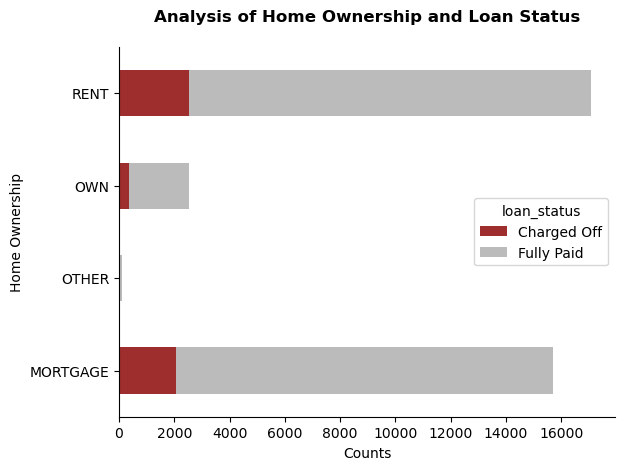

In [70]:
plt.figure(figsize=(10,4))
pd.crosstab(df['home_ownership'] , df['loan_status']).plot(kind = 'barh', stacked = True,color =['#9e2e2e','#bbbbbb'])
plt.title('Analysis of Home Ownership and Loan Status\n',fontweight='bold')
plt.xlabel('Counts')
plt.ylabel('Home Ownership')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Charged off borrowers have their house as rented rather than owning or mortgage

##### Income Source Verification vs Loan Status

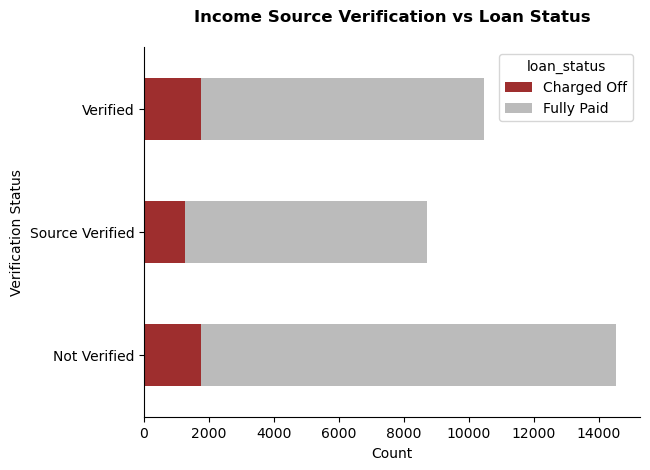

In [71]:
pd.crosstab(df1['verification_status'] ,df1['loan_status']).plot(kind='barh',stacked = True,color =['#9e2e2e','#bbbbbb'])
plt.title('Income Source Verification vs Loan Status\n',fontweight='bold')
plt.ylabel('Verification Status')
plt.xlabel('Count')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### There is almost no difference between not-verified and verified in verification status of income

##### Correlation between numerical Columns

In [72]:
num = df[['loan_amnt','term','int_rate','installment','annual_inc','dti','inq_last_6mths','revol_util']].corr()

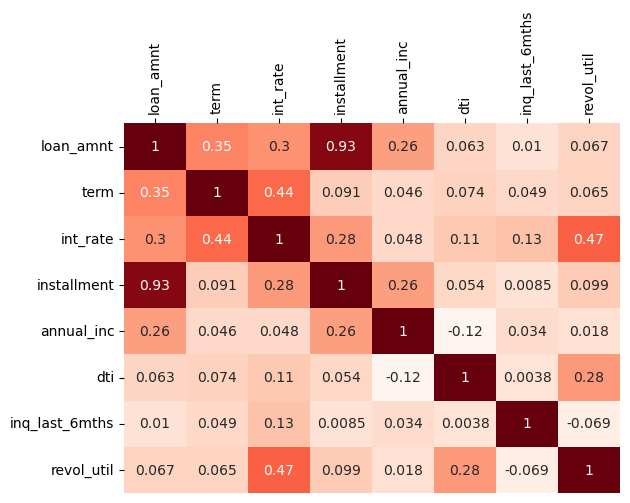

In [73]:
ax = sns.heatmap(num,annot=True,cmap='Reds',cbar=False)
ax.xaxis.tick_top()
plt.xticks(rotation = 90)
plt.show()

##### Lets see is there any relation between address State and sanctioned Loan

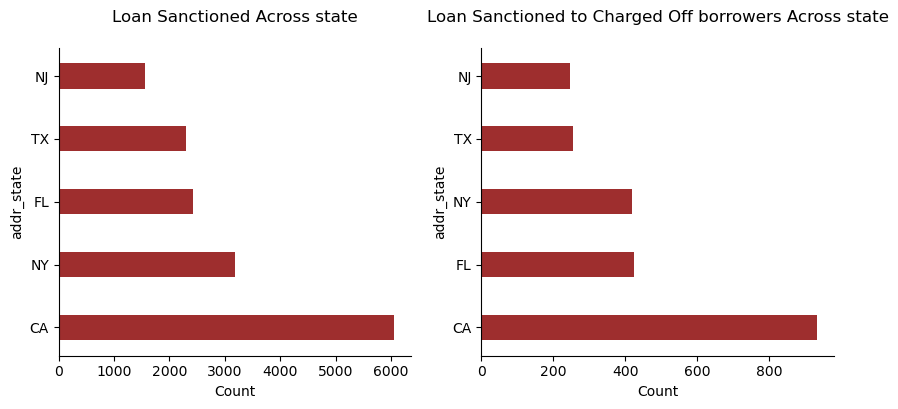

In [74]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df1['addr_state'].value_counts().nlargest(5).plot(kind='barh',width=0.4,color='#9e2e2e')
plt.xlabel('Count')
plt.title('Loan Sanctioned Across state\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.subplot(1,2,2)
charged_off['addr_state'].value_counts().nlargest(5).plot(kind='barh',width=0.4,color='#9e2e2e')
plt.xlabel('Count')
plt.title('Loan Sanctioned to Charged Off borrowers Across state\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Since a high number of loans are sanctioned in CA state ,so as defaulters in CA 

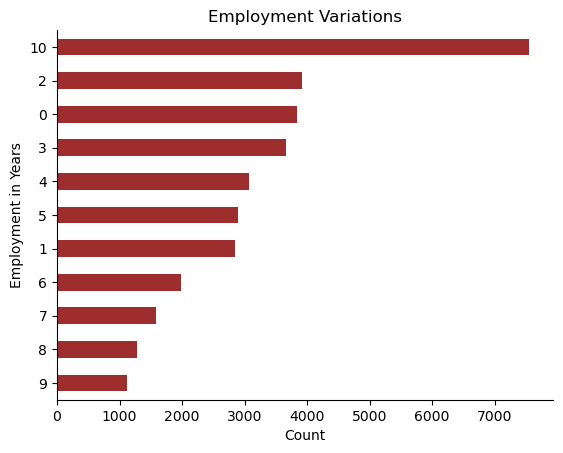

In [75]:
df1['emp_length'].value_counts().sort_values().plot(kind='barh',color='#9e2e2e')
plt.xlabel('Count')
plt.ylabel('Employment in Years')
plt.title('Employment Variations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

##### Lets see how annual Income varies with employment duration in `Charged Off` and `Fully Paid` borrowers

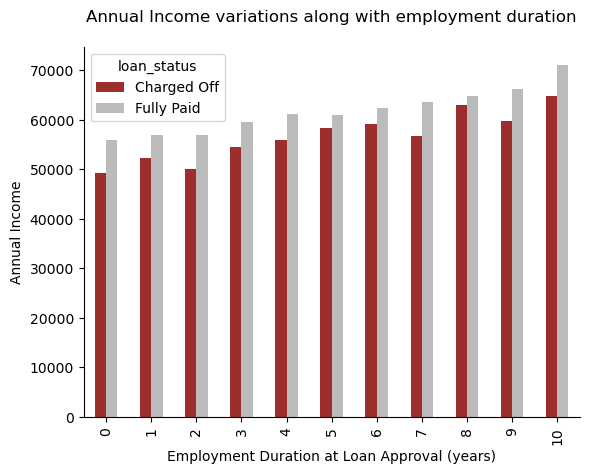

In [76]:
df1.groupby(['loan_status','emp_length'])['annual_inc'].mean()
pd.pivot_table(data=df1 , index='loan_status',columns='emp_length',values='annual_inc',aggfunc='mean').T.plot(kind='bar',color =['#9e2e2e','#bbbbbb'])
plt.xlabel('Employment Duration at Loan Approval (years)')
plt.ylabel('Annual Income')
plt.title('Annual Income variations along with employment duration\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Charged off borrowers have low annual income than fully paid irrespective of their employment duration

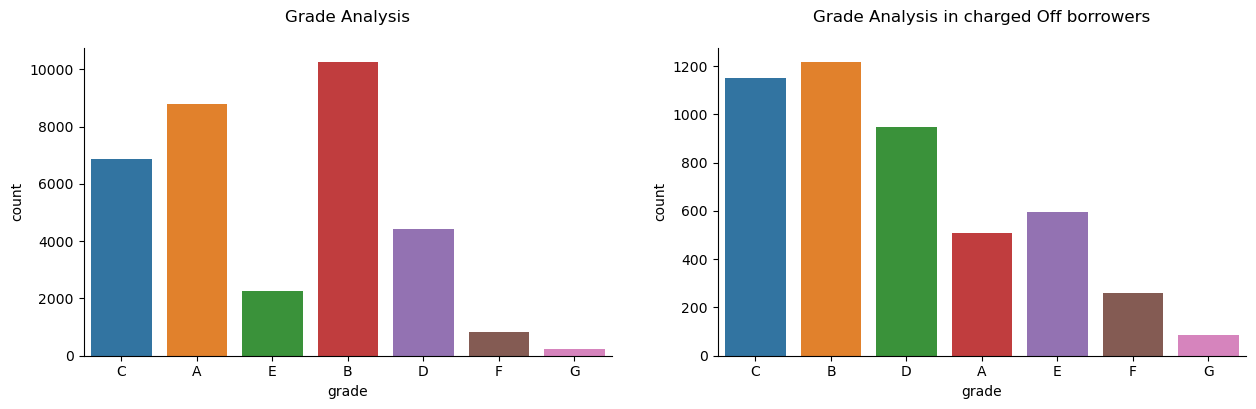

In [77]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.countplot(x = df1['grade'])
plt.title('Grade Analysis\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.subplot(1,2,2)
sns.countplot(x = charged_off['grade'])
plt.title('Grade Analysis in charged Off borrowers\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

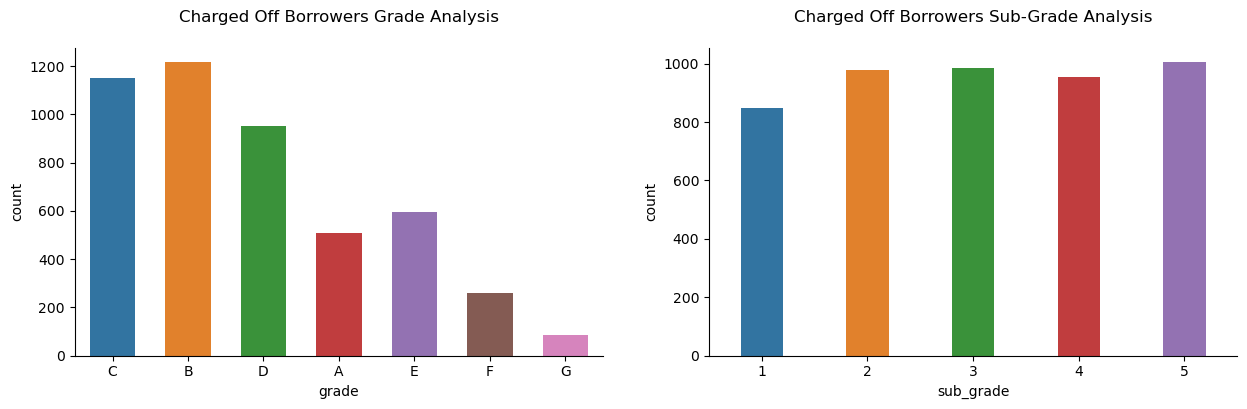

In [78]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.countplot(x = charged_off['grade'],width=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Charged Off Borrowers Grade Analysis\n')
plt.subplot(1,2,2)
sns.countplot(x = charged_off['sub_grade'],width=0.4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Charged Off Borrowers Sub-Grade Analysis\n')
plt.show()

### Borrowers having grade B,C,D and subgrade  2 to 5 are more likely to default

### Key Insights And Observations

#####  1) Charged Off borrowers are paying High Interest rate than fully paid, due to increased interest rate on outstanding loan amount or late fees because of failing in paying installment or emi

##### 2) Highest utilization of revolving credit line in percentage in case of charged off borrowers is   50-75% slab whereas it is 25 -50% slab in fully paid borrowers.

##### 3) It is visible from graph that there is significant difference between number of charged off borrowers who have their rented or mortgage house rather than they own their house

##### 4) Apart from debt consolidation these are the major purpose for which loan is requested .Large number of Charged Off borrowers has taken loan for Small Business and credit card debt cosolidation.

##### 5) Charged Off borrowers having grade B & C with Sub grade 2 to 5 ,are more likely to default on Loan .

##### 6)Charged off borrowers have low annual income than fully paid irrespective of their employment duration

##### 7) Since a high number of loans are sanctioned in CA state ,so as defaulters in CA

##### 8) There is almost no difference between not-verified and verified in verification status of income
